# AARRR 분석

## 1. 분석 상황

E-commerce 데이터를 활용하여 비즈니스 지표를 정의하고 분석 결과를 도출해 본다.

AARRR을 포함한 **비즈니스 지표는 정답이 없으며 회사의 상황과 의사결정자의 판단에 따라 적절한 지표를 선택해주는 것이 중요**하다.

## 2. 데이터 설명

- 데이터 출처: https://archive.ics.uci.edu/dataset/502/online+retail+ii
- 컬럼 설명
    - `InvoiceNo`: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
    - `StockCode`: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
    - `Description`: Product (item) name. Nominal.
    - `Quantity`: The quantities of each product (item) per transaction. Numeric.
    - `InvoiceDate`: Invice date and time. Numeric. The day and time when a transaction was generated.
    - `UnitPrice`: Unit price. Numeric. Product price per unit in sterling (Â£).
    - `CustomerID`: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
    - `Country`: Country name. Nominal. The name of the country where a customer resides.

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from scipy.stats import shapiro

## 문제 1: 데이터 로드 및 탐색

- 데이터의 첫 5개 행을 출력하여 데이터 형식을 확인한다.
- 데이터프레임의 컬럼 정보와 결측치 여부를 확인하고 전처리 전략을 고민한다.

In [81]:
# 데이터 불러오기
file_path = 'online_retail_II.xlsx'

df_2009_2010 = pd.read_excel(file_path, sheet_name='Year 2009-2010')
df_2010_2011 = pd.read_excel(file_path, sheet_name='Year 2010-2011')

# 두 개의 데이터프레임 합치기
df = pd.concat([df_2009_2010, df_2010_2011], ignore_index=True)

In [82]:
# 데이터의 첫 5개 행 출력
print("데이터 상위 5개 행:")
df.head()

데이터 상위 5개 행:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [83]:
# 데이터프레임의 컬럼 정보 및 결측치 확인
print("\n컬럼 정보:")
df.info()

print("\n컬럼별 결측치 개수:")
print(df.isnull().sum())


컬럼 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB

컬럼별 결측치 개수:
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


컬럼 정보
- InvoiceDate는 datetime 타입으로 잘 변환되어 있는 것을 확인할 수 있다.

- Customer ID는 float형인데, ID는 정수형 데이터이기 때문에 int 또는 string 타입 변환을 고려할 수 있다.

컬럼별 결측치
- Description: 4,382건의 결측치 존재  
    → 상품 정보가 없는 것으므로, 상품 관련 분석 시 제외할 수 있다.

- Customer ID: 243,007건의 결측치 존재  
    → 약 22%로 결측이 상당히 많은데, 결측치가 있는 행은 AARRR 등의 회원 분석에는 사용할 수 없다.  
    → drop하기

- 나머지 컬럼은 결측치가 없다.

<br>

## 문제 2: 데이터 전처리

- `InvoiceDate` 컬럼을 날짜 형식으로 변환하고, `Customer ID`에 결측치가 있는 행을 제거한다.
- `Customer ID`를 정수형으로 변환한 후, `InvoiceDate`를 기준으로 데이터를 정렬한다.
- 금액을 나타내는 새로운 컬럼 `Total` 을 생성한다. (`Quantity`와 `Price`를 곱한 값)

In [84]:
# 1. InvoiceDate 컬럼을 날짜형으로 변환 (이미 datetime이지만 혹시 모르니 변환해 준다)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 2. Customer ID에 결측치가 있는 행 제거
df = df.dropna(subset=['Customer ID'])

# 3. Customer ID를 정수형으로 변환
df['Customer ID'] = df['Customer ID'].astype(int)

# 4. InvoiceDate를 기준으로 데이터 정렬
df = df.sort_values('InvoiceDate')

# 5. Total 컬럼 생성 (Quantity × Price)
df['Total'] = df['Quantity'] * df['Price']

df.head(3)

<ipython-input-84-4b0d6b3bf0cf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Customer ID'] = df['Customer ID'].astype(int)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 824364 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      824364 non-null  object        
 1   StockCode    824364 non-null  object        
 2   Description  824364 non-null  object        
 3   Quantity     824364 non-null  int64         
 4   InvoiceDate  824364 non-null  datetime64[ns]
 5   Price        824364 non-null  float64       
 6   Customer ID  824364 non-null  int64         
 7   Country      824364 non-null  object        
 8   Total        824364 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 62.9+ MB


- 전처리 과정에서는 고객 분석을 위한 정확성을 확보하기 위해 Customer ID가 결측된 거래를 제거하고,   
- Customer ID를 정수형으로 변환하여 데이터 일관성을 확보하였다.  

- 또한 InvoiceDate 컬럼은 datetime 타입으로 변환하여 시간 데이터 분석이 가능하도록 정제하였으며,   
- 거래별 금액 정보를 나타내는 Total 컬럼을 새롭게 생성하였다.

이제 AARRR 분석을 위한 데이터셋을 준비되었다.

<br>



## 문제 3: 나라별 구매 인원 시각화

`Country` 컬럼을 기준으로 `Customer ID`의 유니크한 값을 계산하여 나라별 구매 고객 수를 시각화 해 본다.

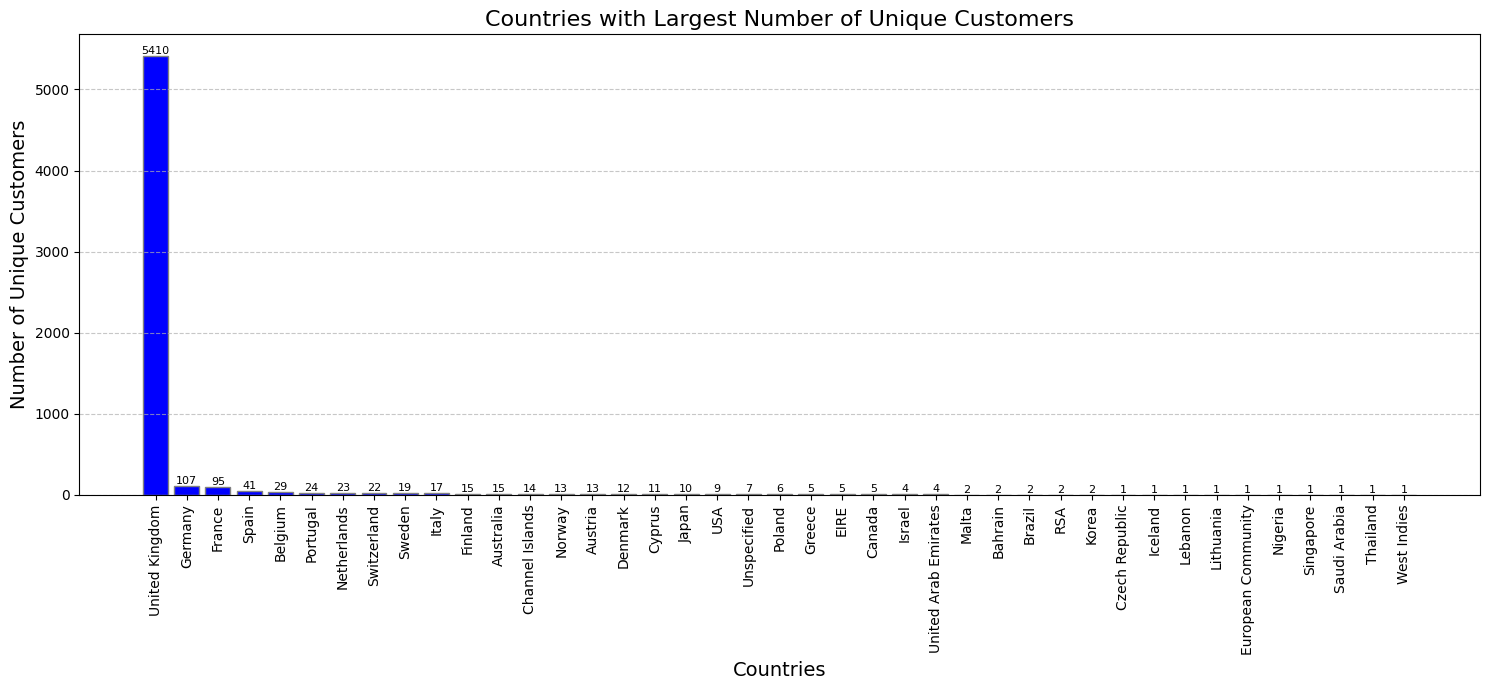

In [86]:
# 나라별로 유니크한 고객 수 계산
country_customer_counts = df.groupby('Country')['Customer ID'].nunique().sort_values(ascending=False)

plt.figure(figsize=(15, 7))
bars = plt.bar(country_customer_counts.index, country_customer_counts.values,
               color='blue', edgecolor='gray')

# 바 위에 수치 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=8)

plt.title('Countries with Largest Number of Unique Customers', fontsize=16)
plt.xlabel('Countries', fontsize=14)
plt.ylabel('Number of Unique Customers', fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

- 전체 거래 중 가장 많은 고객 수를 보유한 나라는 영국(United Kingdom)으로 나타났다.  
영국 고객 수는 5,410명으로 다른 나라와 비교했을 때 압도적으로 많은 비율을 차지했다.

- 그 외 독일, 프랑스, 스페인 등의 유럽 나라들이 소수의 고객층을 보유하고 있었다.

이를 통해 플랫폼의 주 사용자는 영국에 집중되어 있으며, 향후 글로벌 시장 확장을 고려할 경우 상위 고객 수를 보유한 나라를 타겟팅하는 전략이 유효할 것으로 판단된다.

<br>



## 문제 4: Acquisition (고객 유입 분석)

- 신규 고객 분석을 위해 고객의 첫 구매 시점을 기준으로 월별 신규 유입 고객 수를 계산한다.
- 각 고객의 첫 구매 날짜를 추출하고, 월별 신규 고객 수를 시각화한다.



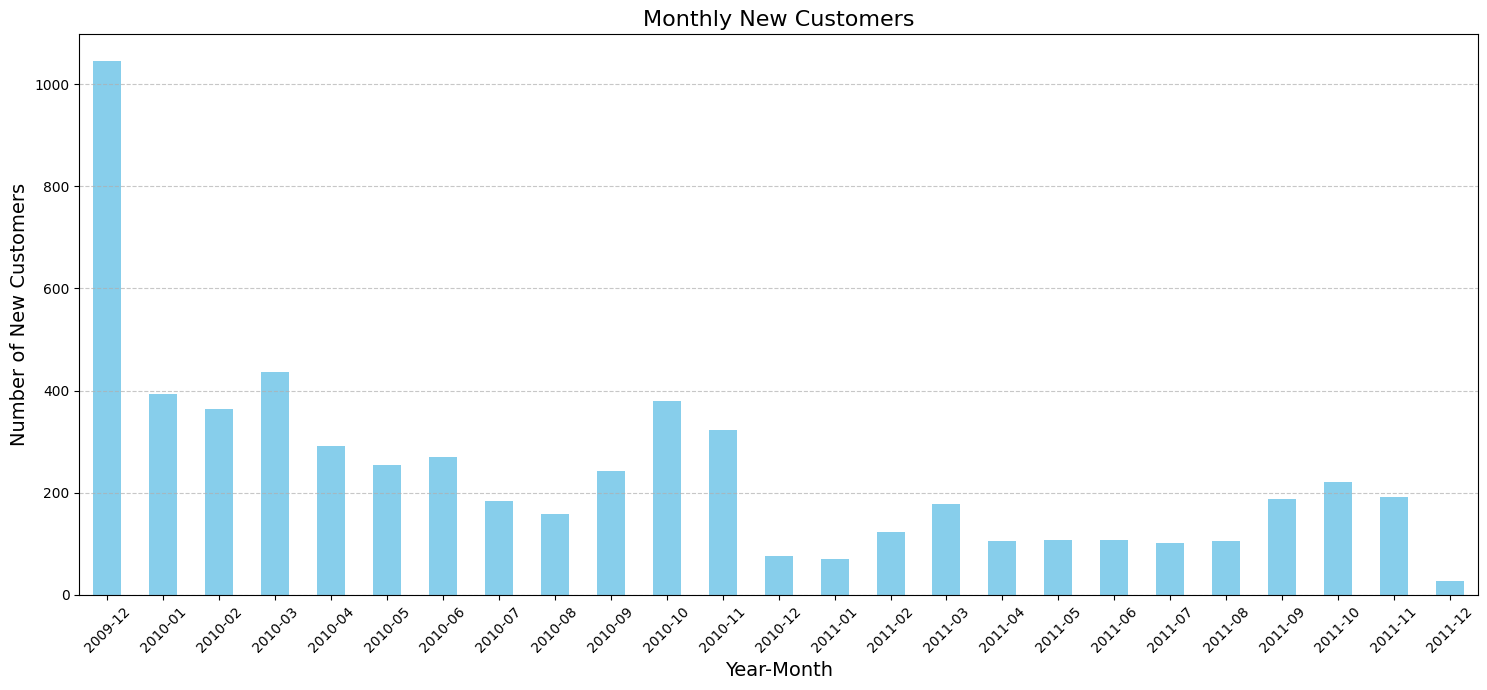

In [87]:
# 1. 고객별 첫 구매 날짜 추출
first_purchase = df.groupby('Customer ID')['InvoiceDate'].min().reset_index()
first_purchase.columns = ['Customer ID', 'FirstPurchaseDate']

# 2. 첫 구매 날짜를 연-월 단위로 변환
first_purchase['YearMonth'] = first_purchase['FirstPurchaseDate'].dt.to_period('M').astype(str)

# 3. 월별 신규 유입 고객 수 집계
new_customers_per_month = first_purchase.groupby('YearMonth').size()

plt.figure(figsize=(15, 7))
bars = plt.bar(new_customers_per_month.index,
               new_customers_per_month.values,
               color='skyblue',
               width=0.5)

plt.title('Monthly New Customers', fontsize=16)
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Number of New Customers', fontsize=14)
plt.xticks(rotation=45)
plt.xlim(-0.5, len(x) - 0.5)  # 좌우 여백 없애기 → 깔끔한 출력을 위해
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

- 2009년 12월에 신규 고객 유입 수가 1,000명 이상으로 가장 많다.

- 2010년 전체를 보면, 초기 몇 개월(2010-01 ~ 2010-03) 동안 상대적으로 유입이 활발했고, 이후 점점 신규 고객 수가 감소하는 경향을 보인다.

- 2010년 10월, 2011년 3월, 2011년 9월 ~ 10월에 유입 수가 일시적으로 증가하는 것을 확인할 수 있다.  
    → 특정 시즌성 이벤트나 프로모션이 있었던 시점일 가능성이 있다.

- 특히 2009년을 제외한 12월, 1월에는 신규 유입 고객 수가 다시 급격히 감소하여 매우 낮아진 것으로 나타난다.  
    → 고객 유입을 유지하기 위해 새로운 마케팅 전략이나 재활성화 캠페인이 필요하다는 것을 생각해 볼 수 있다.

초기 대규모 유입 이후 고객 Acquisition이 대체로 감소하는 경향을 보이며,  
(아마) 시즌성 이벤트를 통한 일시적 증가 외에는 지속적인 신규 고객 확보가 어려운 구조임을 고려해야 한다.

<br>

## 문제 5: Activation (고객 활성화 분석)

- 모든 고객 중 첫 구매 이후 총 구매 금액이 특정 기준 금액 (£50) 이상인 고객을 활성화된 고객으로 정의한다.
- 전체 고객 수와 활성화된 고객 수를 비교하여 활성화율을 도출한다.

In [88]:
# 1. Customer ID별 총 구매 금액 계산
customer_total_spent = df.groupby('Customer ID')['Total'].sum()

# 2. 전체 고객 수
total_customers = customer_total_spent.shape[0]

# 3. 활성화된 고객 수 (총 구매 금액이 £50 이상인 고객)
activated_customers = customer_total_spent[customer_total_spent >= 50].shape[0]

# 4. 활성화율 계산
activation_rate = activated_customers / total_customers * 100

print(f"총 고객 수: {total_customers}")
print(f"활성화된 고객 수 (첫 구매 후 £50 이상 지출한 고객): {activated_customers}")
print(f"고객 활성화율: {activation_rate:.2f}%")

총 고객 수: 5942
활성화된 고객 수 (첫 구매 후 £50 이상 지출한 고객): 5777
고객 활성화율: 97.22%


첫 구매 이후 £50 이상 지출한 고객을 활성화된 고객으로 정의했을 때, 전체 고객 대비 약 97% 이상이 활성화되어 고객들의 초기 만족도가 매우 높음을 알 수 있다. 또한 재구매를 유도하는 전략도 잘 작용했을 가능성이 높다.

<br>


### +) &nbsp;활성화된 고객의 지출 수준별 세그먼트 분석

활성화 고객과 비활성화 고객의 평균 지출액을 비교하고자 했으나, 전체 고객의 97%가 활성화되어 샘플 불균형 발생할 수 있다고 판단했다.

전체 고객의 97%가 활성화되어 있으니, 단순히 £50만 넘은 고객과 아주 많이 지출한 고객을 구분하여 활성화 고객 안에서 가치가 높은 고객이 얼마나 되는지 확인해 보고자 한다.

In [58]:
# 활성화된 고객의 총 구매 금액 세그먼트 나누기
bins = [50, 100, 500, 1000, np.inf]  # 지출 구간
labels = ['£50-£100', '£100-£500', '£500-£1000', '£1000+']

activated['Segment'] = pd.cut(activated, bins=bins, labels=labels)

# 각 세그먼트별 고객 수 확인
segment_counts = activated['Segment'].value_counts().sort_index()

print(segment_counts)

Total
£50-£100       150
£100-£500     1829
£500-£1000    1107
£1000+        2691
Name: count, dtype: int64


활성화된 고객을 총 구매 금액 기준으로 세분화한 결과
- £1000 이상 지출한 고객이  가장 높은 비율(46.6%)을 차지하는 것으로 나타났다.  
- 반면, 단순히 £50 이상만 지출한 고객(£50–£100 구간)은 전체 활성화 고객의 약 2.6%에 불과하여, 활성화 기준을 넘었다고 해서 모든 고객이 동일한 가치를 지니는 것은 아님을 확인할 수 있었다.

활성화된 고객군 내에서도 구매력에 따라 추가적인 타겟팅과 차별화된 전략이 필요하다는 것을 생각해 볼 수 있다.

<br>


## 문제 6: Retention:코호트 분석(고객)

- 분기별 활성 사용자(MAU)를 분석하여 고객 유지 현황을 파악한다.
- 분기별 활성 고객 수를 계산하고, 이를 시각화하여 고객 유지 트렌드를 분석한다.

**Cohort Index 기반 분기 단위 고객 유지율(Retention Rate)**

- 고객의 첫 구매 분기(CohortQuarter) 를 기준으로, 각 고객이 몇 분기 후(OrderQuarter) 에도 재구매 혹은 재방문했는지를 계산하여 분기 단위 유지율을 계산한다.


In [131]:
# 1. OrderQuarter, CohortQuarter 추출
#   OrderQuarter: 구매 일자를 분기로 변환
#   CohortQuarter: 각 고객이 처음 구매한 분기 → 고객별로 그룹화해서 OrderQuarter 중 min값을 구함
df['OrderQuarter'] = df['InvoiceDate'].dt.to_period('Q')
df['CohortQuarter'] = df.groupby('Customer ID')['OrderQuarter'].transform('min')

# 2. CohortIndex 계산
#   고객의 첫 방문 이후 몇 분기 경과했는지를 계산한다.
def get_quarter_diff(row):
    start = row['CohortQuarter']
    end = row['OrderQuarter']
    return (end.year - start.year) * 4 + (end.quarter - start.quarter)

df['CohortIndex'] = df.apply(get_quarter_diff, axis=1)

# 3. Cohort별 고객 수 집계
cohort_data = df.groupby(['CohortQuarter', 'CohortIndex'])['Customer ID'].nunique().unstack(1)

# 4. Retention 계산
#  → 유입 고객 중 몇 %가 특정 시점까지 유지되었는가
cohort_sizes = cohort_data.iloc[:, 0]  # CohortIndex 0 시점: 최초 유입
retention = cohort_data.divide(cohort_sizes, axis=0) * 100
retention.index = [f"Q{q.quarter}/{q.year}" for q in retention.index]  # y축 레이블 포맷

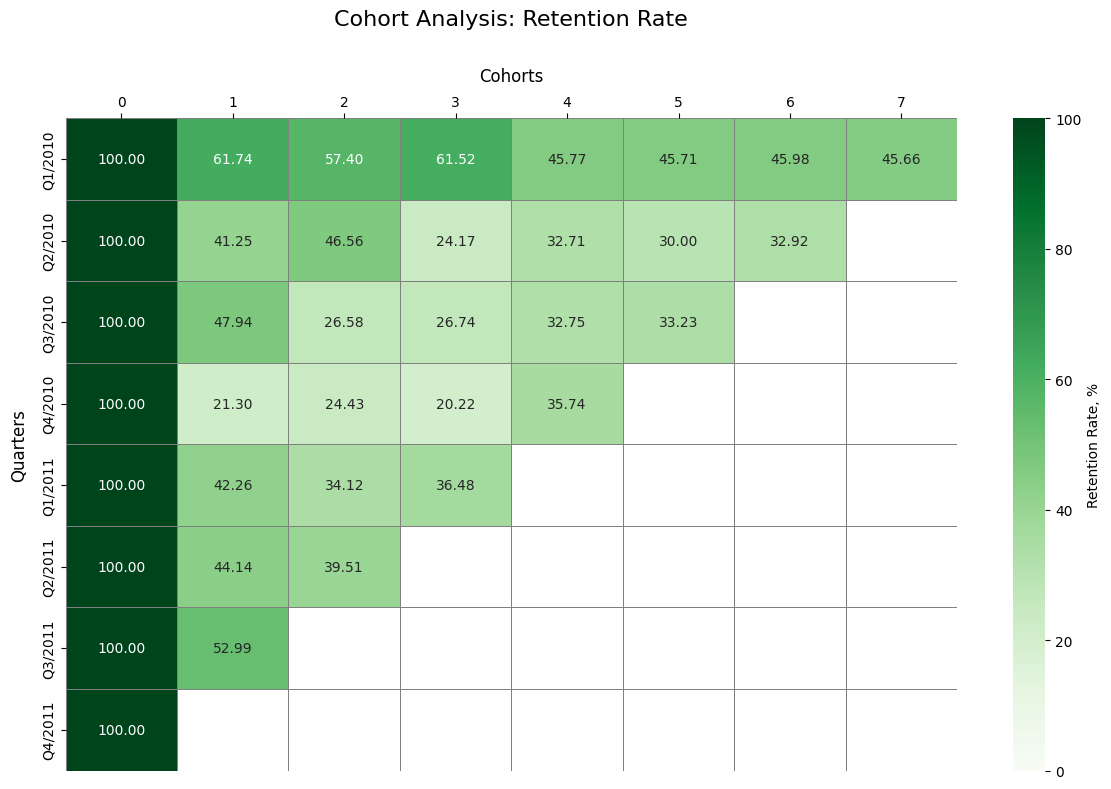

In [132]:
# 히트맵 시각화
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    data=retention,
    annot=True,                    # 셀 내부에 값 표시
    fmt='.2f',                     # 텍스트 형식 (소수점 2자리)
    cmap='Greens',                 # 색상 팔레트
    cbar_kws={'label': 'Retention Rate, %'}, # 컬러바 제목
    linewidths=0.5,                # 셀 간격
    linecolor='gray',              # 셀 경계선 색
    vmin=0, vmax=100               # Retention Rate의 범위 설정
)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_yticklabels(ax.get_yticklabels(), rotation=90)

plt.title('Cohort Analysis: Retention Rate', fontsize=16, pad=30)
plt.xlabel('Cohorts', fontsize=12, labelpad=10)
plt.ylabel('Quarters', fontsize=12, labelpad=10)

plt.tight_layout()
plt.show()

- Q1/2010은 전체적으로 높은 유지율을 기록 (최대 61.74%)

- Q4/2010은 초기 유지율이 낮음 (21.3%) → 마케팅 효과 저조 가능성

- Q1/2011은 초기 유지율(42.26%)은 좋으나 이후 유지가 상대적으로 약함

<br>


## 문제 7: Retention: 코호트 분석(평균 구매수량)

- 분기단위의 활성 사용자의 평균 구매수량을 분석
    - 구매수량이기 때문에 0 index의 값이 100% 가 아닌 절대 값임을 주의

고객이 처음 구매한 분기(cohort 기준) 이후로 각 분기마다 평균 구매 수량이 어떻게 변하는지를 분석한다.

- 단순 유지율(%) 분석이 아니라, 실제 구매 수량의 변화를 파악
- 특정 코호트가 시간이 지남에 따라 구매량이 증가하는지, 감소하는지, 얼마나 적극적인지를 분석할 수 있다.



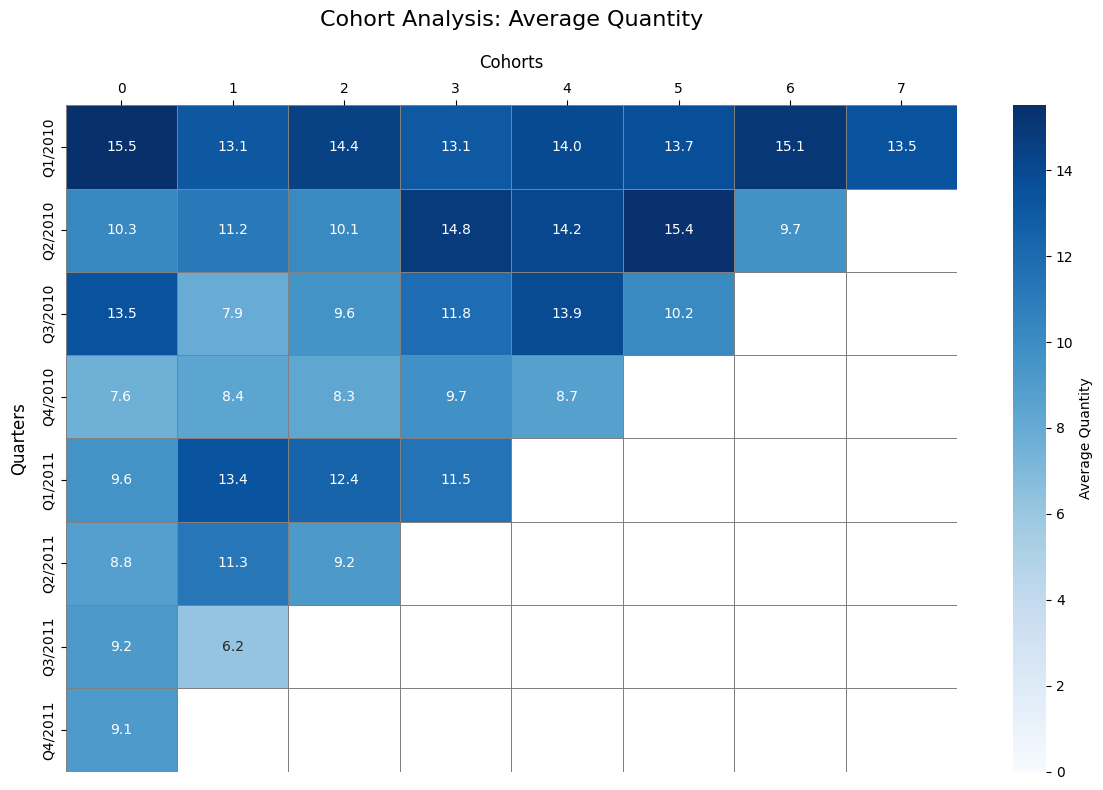

In [170]:
# 평균 구매수량 집계
average_quantity = df.groupby(['CohortQuarter', 'CohortIndex'])['Quantity'].mean().unstack(1)
average_quantity.index = [f"Q{q.quarter}/{q.year}" for q in average_quantity.index]  # y축 레이블 포맷

# 히트맵 시각화
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    data=average_quantity,
    annot=True,
    fmt='.1f',
    cmap='Blues',
    cbar_kws={'label': 'Average Quantity'},
    linewidths=0.5,
    linecolor='gray',
    vmin=0
)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_yticklabels(ax.get_yticklabels(), rotation=90)

plt.title('Cohort Analysis: Average Quantity', fontsize=16, pad=20)
plt.xlabel('Cohorts', fontsize=12, labelpad=10)
plt.ylabel('Quarters', fontsize=12, labelpad=10)

plt.tight_layout()
plt.show()

Retention은 고객이 존재만 하면 "0 또는 1" 로 남지만,  
구매수량은 활동성을 보여주기 때문에 고객이 남아있다고 해서 구매를 활발히 한다는 보장은 없다.

<br>

- 모든 코호트가 0번째 분기에서 구매수량이 가장 높은 것은 아니다. 오히려 시간이 경과한 후 구매량이 증가하는 경우가 다수 존재하는 것을 확인할 수 있다.

- 특히 Q2/2010 코호트처럼
초기에 구매량이 낮았다가 3~5분기 사이에 다시 급격히 증가하는 경우는 재구매 유도 캠페인 등의 마케팅이 효과를 본 결과일 수 있다.

일부 코호트에서는 시간이 지남에 따라 구매량이 증가하는 현상도 나타나기 때문에, 초기 구매량만을 보고 고객 가치를 결정하는 것은 위험하다는 판단을 할 수 있다.

<br>



## 문제 8: Revenue : ARPU

- 각 고객의 월별 구매 금액을 집계하고, 이를 기반으로 ARPU를 분석한다.

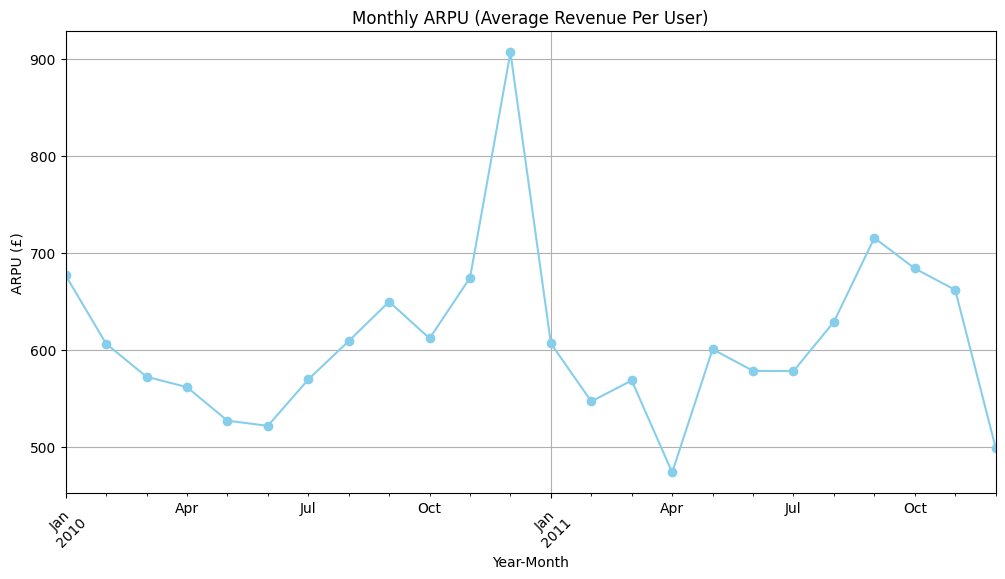

In [171]:
# 1. 월별 구매 금액 합계
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# 2. 고객별 월별 구매 금액 집계
monthly_revenue = df.groupby(['InvoiceMonth', 'Customer ID'])['Total'].sum()

# 3. ARPU 계산 (월별 총 매출 / 월별 고객 수)
arpu = monthly_revenue.groupby('InvoiceMonth').mean()

plt.figure(figsize=(12, 6))
arpu.plot(kind='line', marker='o', color='skyblue')
plt.title("Monthly ARPU (Average Revenue Per User)")
plt.xlabel("Year-Month")
plt.ylabel("ARPU (£)")
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

ARPU (Average Revenue Per User)란?

사용자 1인당 평균 매출로, 고객 한 명이 일정 기간 동안 창출한 수익을 나타낸다. 이를 통해 비즈니스 수익성과 고객 가치를 동시에 파악할 수 있다.

- ARPU가 연말 시즌에 급격히 증가하는 것을 확인할 수 있는데, 시즌별 프로모션 등의 이벤트가 고객당 수익을 크게 높일 수 있음을 알 수 있다.

- 이후 상반기의 ARPU가 비교적 낮은 편이기 때문에, 비시즌에도 고객당 구매를 늘리기 위한 전략이 필요하다.

-  ARPU 하락은 고객당 구매 빈도 감소 또는 구매액 감소를 의미할 수 있다. 단순한 유입보다 고객당 소비를 늘리는 전략이 필요하다.

- 장기적으로 ARPU를 높이는 것은 고객 생애가치(LTV)를 키우는 것으로 이어지기 때문에 장기 수익성 확보로 연결될 수 있다.

ARPU 분석을 통해 고객당 수익 변동을 파악하고, 이를 기반으로 시즌별 마케팅 전략과 고객 유지 전략을 수립하여 장기적인 수익성을 확보할 수 있다.

<br>

## 문제 9: Revenue(CLV)

- 고객 생애 가치를 예측하기 위해 CLV를 계산하고 표로 CLV기준으로 내림차순으로 정렬한다.
- CLV 식: 평균금액 x  평균 구매 빈도 x 고객유지기간(단, Invoce Date의 최대 최소를 빼준 뒤 1을 더해주기)

In [223]:
# 1. 고객별 요약 데이터 준비
customer_data = df.groupby('Customer ID').agg({
    'Total': 'sum',                       # 총 지출 금액
    'InvoiceDate': ['min', 'max'],        # 첫 구매일과 마지막 구매일
    'Invoice': 'nunique'                  # 구매건수 (예시 출력처럼 중복 포함하려면 'count')
}).reset_index()

# 2. 컬럼명 정리
customer_data.columns = ['Customer ID', 'Total Revenue', 'FirstPurchaseDate', 'LastPurchaseDate', 'Frequency']

# 3. 고객 유지기간: 최대 - 최소 + 1일
customer_data['Customer Lifespan (days)'] = (
    customer_data['LastPurchaseDate'] - customer_data['FirstPurchaseDate']
).dt.days + 1

# 4. 평균 구매 금액
customer_data['AverageAmount'] = customer_data['Total Revenue'] / customer_data['Frequency']

# 5. 평균 구매 빈도 (일 단위)
customer_data['AvgFrequency'] = customer_data['Frequency'] / customer_data['Customer Lifespan (days)']

# 6. CLV: 평균금액 × 평균구매빈도 × 고객유지기간
customer_data['CLV'] = (
    customer_data['AverageAmount'] *
    customer_data['AvgFrequency'] *
    customer_data['Customer Lifespan (days)']
)

average_clv = customer_data[[
    'Customer ID', 'CLV', 'Total Revenue', 'Frequency', 'Customer Lifespan (days)'
]].copy()

# 7. CLV 기준으로 내림차순 정렬
average_clv = average_clv.sort_values(by='CLV', ascending=False)
average_clv

,Customer ID,CLV,Total Revenue,Frequency,Customer Lifespan (days)
5659,18102,557209.48,557209.48,144,703
2274,14646,508645.60,508645.60,159,696
1788,14156,285539.97,285539.97,192,695
2534,14911,264074.59,264074.59,494,700
5020,17450,233579.39,233579.39,61,430
...,...,...,...,...,...
3455,15849,-5876.34,-5876.34,1,1
3026,15413,-7044.80,-7044.80,4,269
1698,14063,-10468.80,-10468.80,9,271
568,12918,-10953.50,-10953.50,3,1


In [218]:
# display(final_clv[final_clv['Customer ID'] == 16000])

In [220]:
average_clv.head(10)

,Customer ID,CLV,Total Revenue,Frequency,Customer Lifespan (days)
5659,18102,557209.48,557209.48,144,703
2274,14646,508645.60,508645.60,159,696
1788,14156,285539.97,285539.97,192,695
2534,14911,264074.59,264074.59,494,700
5020,17450,233579.39,233579.39,61,430
1332,13694,170397.61,170397.61,152,701
5079,17511,163518.17,163518.17,83,687
69,12415,143269.29,143269.29,33,504
4272,16684,138615.93,138615.93,62,687
2679,15061,122078.94,122078.94,129,695


In [221]:
average_clv.tail(10)

,Customer ID,CLV,Total Revenue,Frequency,Customer Lifespan (days)
4594,17013,-3224.76,-3224.76,2,1
5580,18023,-3248.86,-3248.86,1,1
3754,16151,-4217.59,-4217.59,1,1
4563,16981,-4620.86,-4620.86,1,1
3368,15760,-5795.87,-5795.87,5,1
3455,15849,-5876.34,-5876.34,1,1
3026,15413,-7044.80,-7044.80,4,269
1698,14063,-10468.80,-10468.80,9,271
568,12918,-10953.50,-10953.50,3,1
4970,17399,-25111.09,-25111.09,1,1


- 고객 생애 가치(Customer Lifetime Value)는  
`평균구매금액 × 평균 구매 빈도 × 고객 유지기간` 으로 계산되었고,  
- 고객 유지기간은 `최종 구매일 - 최초 구매일 + 1일` 로 정의하였다.

<br>

CLV가 높은 고객들은 다음과 같은 특징을 보인다.

- 총 매출(Total Revenue)이 높고
- 거래 횟수(Frequency)가 많으며
- 고객 유지기간(Customer Lifespan)이 길다.  
    → 이들은 자주, 오래, 많이 소비하는 충성 고객으로 분할 수 있다.


CLV가 낮거나 음수인 고객들은 대체로 다음과 같은 특징을 보인다.

- 구매 횟수가 매우 적음 (10회 이하)
- 유지기간이 1일 이하
    → 이들은 이탈 고객 혹은 불만족 고객일 가능성이 높다.

<br>


### +) &nbsp;CLV 분포 시각화

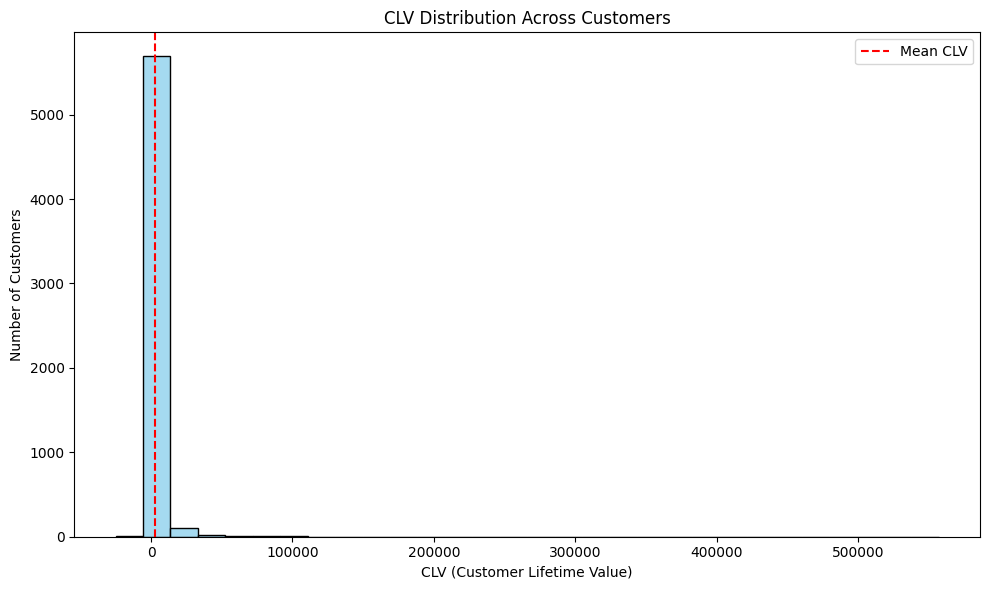

In [226]:
# 2. 히스토그램으로 CLV 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(data=average_clv, x='CLV', bins=30, kde=False, color='skyblue')

# 3. 평균 CLV 선
plt.axvline(average_clv['CLV'].mean(), color='red', linestyle='--', label='Mean CLV')

plt.title('CLV Distribution Across Customers')
plt.xlabel('CLV (Customer Lifetime Value)')
plt.ylabel('Number of Customers')
plt.legend()
plt.tight_layout()
plt.show()

히스토그램을 통해 CLV 분포를 시각화했지만, 대부분의 고객이 낮은 CLV 구간(0~5천)에 몰려 있어, CLV가 매우 높은 일부 고객들은 그래프 상에서 거의 보이지 않는 문제를 확인할 수 있다.

이를 보완하기 위해 CLV 값을 여러 구간으로 나누어 각 구간별 고객 수를 집계해 보았다.

In [236]:
# 구간별 고객 수 확인
bins = [float('-inf'), 0, 5000, 10000, 100000, 500000, float('inf')]
labels = ['≤0', '0~5k', '5k~10k', '10k~100k', '100k~500k', '>500k']

average_clv['CLV Group'] = pd.cut(average_clv['CLV'], bins=bins, labels=labels)

# 각 구간별 고객 수
group_counts = average_clv['CLV Group'].value_counts().sort_index()
print(group_counts)

CLV Group
≤0             89
0~5k         5143
5k~10k        371
10k~100k      227
100k~500k      10
>500k           2
Name: count, dtype: int64


대부분의 고객(5,143명)이 0~5천 CLV 구간에 몰려 있었고,  
 CLV가 10만을 초과하는 고객은 12명에 불과함을 확인할 수 있다.

이 과정을 통해, 소수의 고 CLV 고객이 전체 매출의 상당 부분을 차지하고 있으며, 이들이 시각적으로는 드러나지 않았지만 데이터 분석을 통해 명확히 존재함을 확인할 수 있었다.

<br>




> AARRR 분석을 통해 고객 대부분은 유입 직후 한두 번의 거래만 진행하고 이탈하는 반면, CLV가 높은 고객이 전체 매출의 큰 비중을 차지한다는 점을 확인할 수 있었다. 특히 연말 시즌에 유입과 매출이 집중되는 경향이 뚜렷했으며, 일부 고객군에서는 일정 시점 이후 구매가 다시 증가하는 현상도 관찰되었다.  
>
>이를 바탕으로 고객의 초기 경험을 개선하고, 이탈 시점을 고려한 재활성화 전략, CLV가 높은 고객을 선별하여 관리하는 것이 수익성을 올리기 위해 필요하다는 결과를 도출해 볼 수 있다.





---

<br>
<br>
<br>


# 통계 분석

## 문제 10

어떤 회사의 고객 대기시간은 5분에서 15분 사이의 균등분포를 따른다.  
고객 100명이 대기한 시간을 시뮬레이션하고, 평균 대기시간과 표준편차를 계산한다.

In [240]:
from scipy.stats import uniform

# 1. 고객 100명의 대기시간을 5분~15분 사이 균등분포로 시뮬레이션
user_count = 100
waiting_times = uniform.rvs(loc=5, scale=10, size=user_count, random_state=0 )

# 2. 평균 대기시간 계산
mean_waiting_time = np.mean(waiting_times)

# 3. 표준편차 계산
std_waiting_time = np.std(waiting_times, ddof=1)

print(f"평균 대기시간: {mean_waiting_time:.2f}")
print(f"표준편차: {std_waiting_time:.2f}")

평균 대기시간: 9.73
표준편차: 2.90


- 평균 대기시간은 약 9.73분으로 나타났다.  
이는 5분~15분 범위에서 균등하게 대기시간이 분포했을 때 평균이 대략 중간값(10분) 근처에 위치하는 것을 의미한다.

- 표준편차는 약 2.90분으로 계산되었다.  
이는 대기시간 데이터가 평균인 9.78분을 중심으로 약 ±3분 범위 내에서 퍼져 있음을 의미한다.

고객들의 대기시간은 평균 9.78분 정도이며, 대부분은 평균을 중심으로 ±3분 이내에 분포해 있다고 해석할 수 있다.

<br>


## 문제 11

한 신제품의 초기 성공 확률이 0.3이라고 가정한다.  
10회의 시뮬레이션에서 성공한 횟수를 구하고, 각 성공 여부를 출력한다.

In [241]:
from scipy.stats import bernoulli

# 성공 확률과 시행수 정의
p = 0.3
n = 10

# 베르누이 분포 샘플 생성
outcomes = bernoulli.rvs(p, size=n)
success_count = outcomes.sum()

print(f"각 시도 결과: {outcomes}")
print(f"성공 횟수: {success_count}")

각 시도 결과: [0 0 1 0 1 0 0 0 0 1]
성공 횟수: 3


베르누이 분포의 기본 성질을 시뮬레이션을 통해 재현한 것이다.  
총 10회 시도 중 3번 성공한 결과를 볼 수 있는데, 이는 설정된 성공 확률 30%와도 잘 부합한다.  
- 10 × 0.3 = 기대 성공 횟수는 3

단일 시행에서는 편차가 있을 수 있지만, 여러 번 반복할수록 이론적인 기대값과 점점 가까워진다.

<br>



## 문제 12

한 수업에서 학생 20명이 5문제로 구성된 퀴즈를 치른다.  
각 문제의 정답 확률은 0.7이라고 가정할 때, 각 학생이 맞힌 점수를 시뮬레이션하고, 전체 학생의 평균 점수를 계산한다.

In [242]:
from scipy.stats import binom

# 이항 분포: 문제 수 , 정답확률, 학생 수
num_of_stds = 20
num_of_quizzes = 5
percent = 0.7

# 각 학생의 점수 시뮬레이션
scores = binom.rvs(num_of_quizzes, p = percent, size=num_of_stds, random_state=0)
average_score = np.mean(scores)

print(f"학생별 점수: {scores}")
print(f"평균 점수: {average_score:.2f}")

학생별 점수: [3 3 3 3 4 3 4 2 2 4 3 3 3 2 5 5 5 3 3 2]
평균 점수: 3.25


학생 20명을 대상으로 한 퀴즈 시뮬레이션에서, 평균적으로 한 학생은 5문제 중 약 3.25문제를 맞혔다.  
이는 기대값(3.5)보다 약간 낮지만, 표본 수가 작기 때문에 발생할 수 있는 자연스러운 변동으로 해석할 수 있다.

<br>


## 문제 13

한 공장에서 생산되는 제품의 무게는 평균 50g, 표준편차 5g의 정규분포를 따른다.1000개의 제품 무게를 시뮬레이션하고, 무게가 45g 이상 55g 이하인 제품의 비율을 계산(변수명: within_range)한다. 무게 분포의 히스토그램을 그린다.

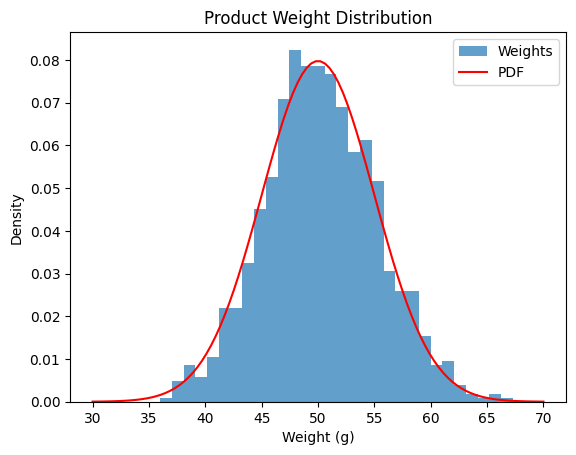

45g 이상 55g 이하 비율: 68.70%


In [280]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. 정규분포 파라미터
mu = 50                # 평균
sigma = 5              # 표준편차
num_of_samples = 1000  # 데이터 샘플 수

# 2. 정규분포 샘플 생성
weights = norm.rvs(loc=mu, scale=sigma, size=num_of_samples, random_state=0)

# 45g 이상 55g 이하의 비율 계산
conds = (weights >= 45) & (weights <=55)
within_range = len(weights[conds]) / len(weights)

# 히스토그램 시각화
plt.hist(weights, bins=30, density=True, alpha=0.7, label="Weights")
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', label="PDF")
plt.xlabel("Weight (g)")
plt.ylabel("Density")
plt.title("Product Weight Distribution")
plt.legend()
plt.show()

print(f"45g 이상 55g 이하 비율: {within_range:.2%}")

- 무게가 50g을 중심으로 대칭적인 종 모양을 가진다.

- 대부분의 데이터가 45g ~ 55g 구간에 몰려 있으며, 이 구간에 약 68% 정도가 분포함을 확인할 수 있다.

- 이는 평균 ± 1 표준편차 (50 ± 5 = 45~55g) 범위에 약 68%가 포함된다는 정규분포의 성질과도 일치한다.

따라서 시뮬레이션 결과가 정규분포 가정과 잘 일치함을 알 수 있다.

<br>

---

<br>
<br>
<br>


# 회고


이번 프로젝트를 통해 사용자 행동의 흐름을 단계별로 연결하여 해석하며 의미있는 결과를 도출하는 과정을 연습해 보았다.

<br>

- 전처리 과정에서 고객 식별이 가능한 데이터만을 선별하여 분석해야 분석 결과의 신뢰성을 높일 수 있다는 것을 체감했다.

- AARRR 각 단계별로 지표를 수립하고, 이를 시각화하여 분석 흐름을 명확히 체계화할 수 있었다.

- 집계한 결과를 이용해 지표 간 관계를 유추하고 행동 패턴을 해석하는 훈련을 할 수 있었다.

- Revenue 분석을 통해 모든 고객을 동일하게 다루는 전략보다는, 핵심 고객군을 선별하여 집중 관리하는 전략이 효과적이겠다는 점을 생각해 볼 수 있었다.

<br>


결론적으로  
>Acquisition, Activation, Retention, Revenue, (+ Referral)의  AARRR 단계를
각각 따로가 아니라 하나의 흐름으로 이해하고 관리해야
수익성을 비롯한 비즈니스 성과를 높일 수 있을 것이라는 사실을 체감했다.  
분석의 목적에 따라 각 단계마다 어떤 지표를 유의해서 살펴봐야 할지를 꾸준히 고민하고 연습해 보아야겠다.

>또한, 시각화 과정에서 Tableau 등의 시각화 도구의 사용을 자유롭게 사용할 수 있도록 연습하는 것이 필요함을 느꼈다. 내가 출력한 결과인데도 해석이 바로 되지 않은 경우가 있었기 때문이다. 데이터에 대한 이해도가 낮은 사람을 상대로 분석 결과를 공유할 때 더욱 직관적으로 전달할 수 있는 역량을 키울 것이다.